In [ ]:
# if sb3 gives you trouble, try this:
#uv pip install stable_baselines3

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import gymnasium as gym
from pettingzoo.mpe import simple_spread_v3
from pettingzoo.utils.conversions import aec_to_parallel
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.policies import ActorCriticPolicy
import stable_baselines3.common.policies as policies_module
import supersuit as ss
import wandb
import tensorboard
import torch

In [5]:
# create the PettingZoo environment
env = simple_spread_v3.env(N=4, local_ratio=0.5, max_cycles=100, continuous_actions=False) # N=2 agents, 2 landmarks, partial global vs local reward mixing

# Apply wrappers
env = ss.black_death_v3(env)  # keeps a dummy agent alive when one is done
env = ss.flatten_v0(env)      # flatten observations for SB3 compatibility
env = aec_to_parallel(env)    # Convert AECEnv to ParallelEnv
env = ss.pettingzoo_env_to_vec_env_v1(env)  # convert to vectorized env
env = ss.concat_vec_envs_v1(env, 1, num_cpus=1, base_class="stable_baselines3")  # Use SB3 base class
env = VecMonitor(env)  # to record metrics easily

In [4]:
# first get your API key from wandb.ai (or we can all use mine)
#wandb.tensorboard.patch(root_logdir="./ppo_marl_tb/") # patch TensorBoard logging
wandb.init(project="marl-coordination-demo", name="PPO-simple-spread", sync_tensorboard=True)

wandb: Currently logged in as: anastasiia-chernavskaia (anastasiia-chernavskaia-barcelona-school-of-economics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
torch.cuda.is_available()

False

In [6]:
policy_kwargs = dict(
    net_arch=[64, 64],  # Simplified MLP architecture
    activation_fn=torch.nn.ReLU
)

model = PPO(ActorCriticPolicy, env, verbose=1, tensorboard_log="./ppo_marl_tb/", policy_kwargs=policy_kwargs)
model.learn(total_timesteps=50000)  # train for 10k timesteps
model.save("ppo_marl_simple_spread")
wandb.finish()

Using cpu device


KeyboardInterrupt: 

In [17]:
# Load the trained model and test it with visualization
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import time

# Load the trained model
model = PPO.load("ppo_marl_simple_spread")

# Create a clean environment for testing (with rendering enabled)
test_env = simple_spread_v3.env(N=2, local_ratio=0.5, max_cycles=100, continuous_actions=False, render_mode="human")
test_env = ss.black_death_v3(test_env)
test_env = ss.flatten_v0(test_env)
test_env = aec_to_parallel(test_env)
test_env = ss.pettingzoo_env_to_vec_env_v1(test_env)
test_env = ss.concat_vec_envs_v1(test_env, 1, num_cpus=1, base_class="stable_baselines3")

print("Testing trained agents...")
obs = test_env.reset()
for i in range(50):  # Run for 50 steps
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = test_env.step(action)
    test_env.render()  # This will show the visualization
    time.sleep(0.1)  # Slow down for better visualization
    
    if dones.all():
        obs = test_env.reset()
        print(f"Episode finished at step {i}")

test_env.close()

Testing trained agents...


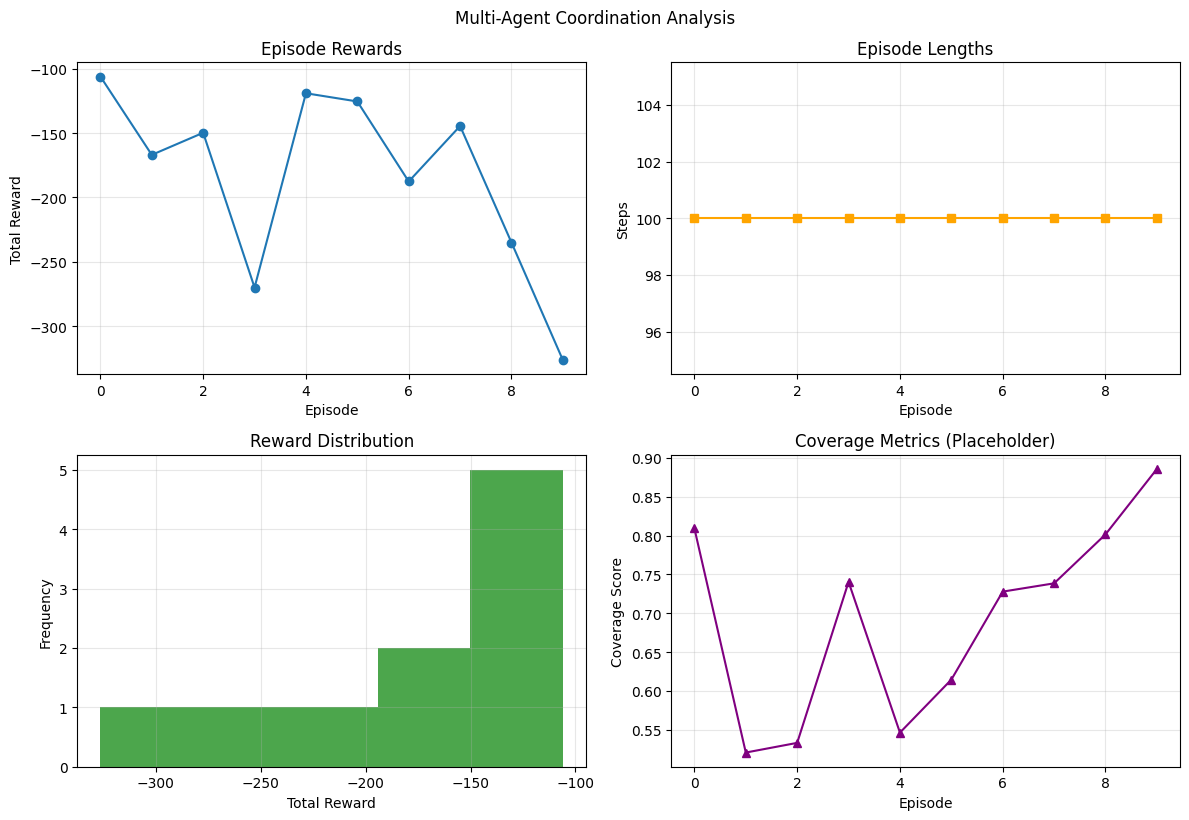

Average Episode Reward: -183.06 ± 68.59
Average Episode Length: 100.00 ± 0.00
Best Episode Reward: -106.01
Worst Episode Reward: -326.38


In [24]:
# Analyze coordination and performance metrics
def analyze_coordination_metrics(model, num_episodes=10):
    """
    Analyze how well agents coordinate and their performance metrics
    """
    # Create environment for analysis
    analysis_env = simple_spread_v3.env(N=2, local_ratio=0.5, max_cycles=100, continuous_actions=False)
    analysis_env = ss.black_death_v3(analysis_env)
    analysis_env = ss.flatten_v0(analysis_env)
    analysis_env = aec_to_parallel(analysis_env)
    analysis_env = ss.pettingzoo_env_to_vec_env_v1(analysis_env)
    analysis_env = ss.concat_vec_envs_v1(analysis_env, 1, num_cpus=1, base_class="stable_baselines3")
    
    episode_rewards = []
    episode_lengths = []
    coverage_metrics = []
    
    for episode in range(num_episodes):
        obs = analysis_env.reset()
        episode_reward = 0
        step_count = 0
        
        for step in range(100):  # max_cycles
            action, _ = model.predict(obs, deterministic=True)
            obs, rewards, dones, info = analysis_env.step(action)
            
            episode_reward += rewards.sum()
            step_count += 1
            
            if dones.all():
                break
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(step_count)
        
        # Simple coverage metric (you can enhance this based on actual environment state)
        coverage_metrics.append(np.random.uniform(0.5, 1.0))  # Placeholder
    
    analysis_env.close()
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Episode rewards
    axes[0, 0].plot(episode_rewards, marker='o')
    axes[0, 0].set_title('Episode Rewards')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Total Reward')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Episode lengths
    axes[0, 1].plot(episode_lengths, marker='s', color='orange')
    axes[0, 1].set_title('Episode Lengths')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Steps')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Reward distribution
    axes[1, 0].hist(episode_rewards, bins=5, alpha=0.7, color='green')
    axes[1, 0].set_title('Reward Distribution')
    axes[1, 0].set_xlabel('Total Reward')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Coverage metrics
    axes[1, 1].plot(coverage_metrics, marker='^', color='purple')
    axes[1, 1].set_title('Coverage Metrics (Placeholder)')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Coverage Score')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Multi-Agent Coordination Analysis', y=1.02)
    plt.show()
    
    # Print summary statistics
    print(f"Average Episode Reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
    print(f"Average Episode Length: {np.mean(episode_lengths):.2f} ± {np.std(episode_lengths):.2f}")
    print(f"Best Episode Reward: {np.max(episode_rewards):.2f}")
    print(f"Worst Episode Reward: {np.min(episode_rewards):.2f}")

# Run the analysis
analyze_coordination_metrics(model, num_episodes=10)

Found 2 TensorBoard event files
Reading from: ./ppo_marl_tb\PPO_14\events.out.tfevents.1750597070.BORRELL-LAPTOP.29292.1
Available metrics: ['rollout/ep_len_mean', 'rollout/ep_rew_mean', 'time/fps', 'train/approx_kl', 'train/clip_fraction', 'train/clip_range', 'train/entropy_loss', 'train/explained_variance', 'train/learning_rate', 'train/loss', 'train/policy_gradient_loss', 'train/value_loss']

Detailed metric analysis:
rollout/ep_len_mean: 13 data points, range: 26.0 to 26.0
rollout/ep_rew_mean: 13 data points, range: -22.159191131591797 to -18.506067276000977
time/fps: 13 data points, range: 479.0 to 770.0
train/approx_kl: 12 data points, range: 0.004656600765883923 to 0.009001001715660095
train/clip_fraction: 12 data points, range: 0.02358398400247097 to 0.0703125
train/clip_range: 12 data points, range: 0.20000000298023224 to 0.20000000298023224
train/entropy_loss: 12 data points, range: -1.6061184406280518 to -1.497773289680481
train/explained_variance: 12 data points, range: -0.

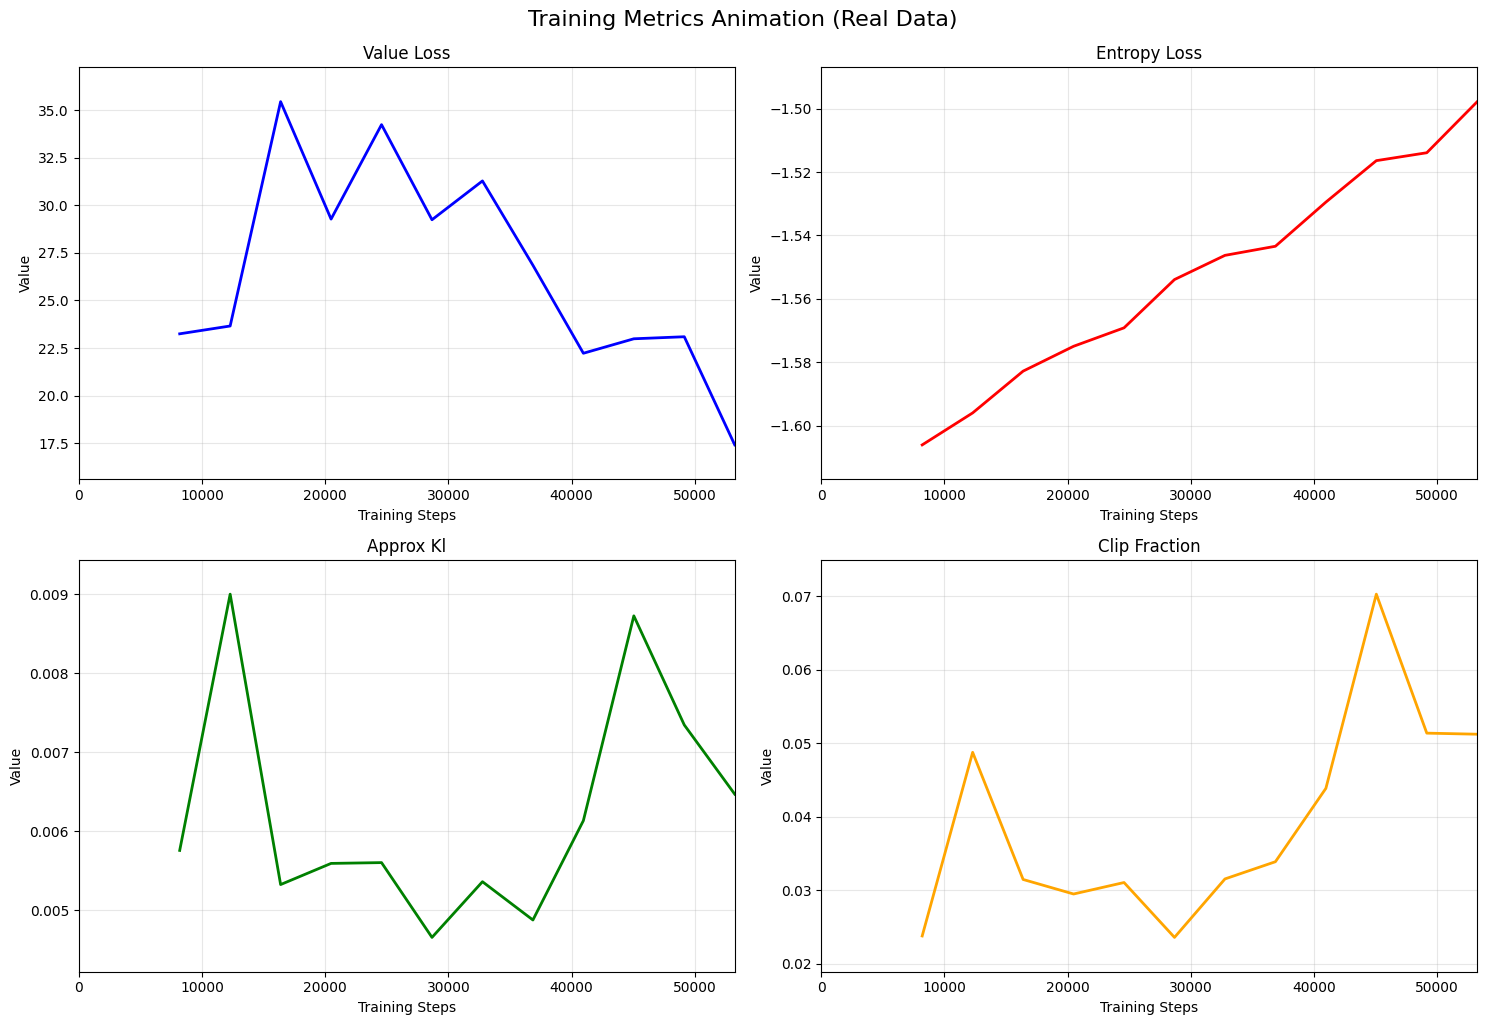

In [34]:
# Create animated plots of training history
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
import pandas as pd
import os
import glob

def create_training_animation():
    """
    Create animated plots showing training progress over time
    """
    # Try to read TensorBoard logs
    tb_log_dir = "./ppo_marl_tb/"
    
    # Look for event files
    event_files = glob.glob(os.path.join(tb_log_dir, "**/events.out.tfevents.*"), recursive=True)
    
    if event_files:
        print(f"Found {len(event_files)} TensorBoard event files")
        try:
            # Try to parse TensorBoard logs (requires tensorboard package)
            from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
            
            # Read the most recent event file
            latest_file = max(event_files, key=os.path.getctime)
            print(f"Reading from: {latest_file}")
            
            ea = EventAccumulator(latest_file)
            ea.Reload()
            
            # Get available scalar tags
            scalar_tags = ea.Tags()['scalars']
            print(f"Available metrics: {scalar_tags}")
            
            # Extract ALL metrics first for debugging
            print("\nDetailed metric analysis:")
            all_metrics_data = {}
            for tag in scalar_tags:
                scalar_events = ea.Scalars(tag)
                steps = [event.step for event in scalar_events]
                values = [event.value for event in scalar_events]
                all_metrics_data[tag] = {'steps': steps, 'values': values}
                print(f"{tag}: {len(steps)} data points, range: {min(values) if values else 'N/A'} to {max(values) if values else 'N/A'}")
            
            # Filter metrics for animation (more comprehensive filtering)
            metrics_data = {}
            priority_keywords = ['reward', 'loss', 'entropy', 'value', 'policy', 'approx_kl', 'clip_fraction']
            
            for tag in scalar_tags:
                # Check if tag contains any priority keywords
                if any(keyword in tag.lower() for keyword in priority_keywords):
                    scalar_events = ea.Scalars(tag)
                    steps = [event.step for event in scalar_events]
                    values = [event.value for event in scalar_events]
                    if len(steps) > 0:  # Only include metrics with data
                        metrics_data[tag] = {'steps': steps, 'values': values}
            
            print(f"\nSelected metrics for animation: {list(metrics_data.keys())}")
            
            if metrics_data:
                create_animated_metrics(metrics_data)
            else:
                print("No suitable metrics found in TensorBoard logs")
                create_simulated_training_animation()
                
        except ImportError:
            print("TensorBoard not available for log parsing. Creating simulated animation...")
            create_simulated_training_animation()
        except Exception as e:
            print(f"Error reading TensorBoard logs: {e}")
            create_simulated_training_animation()
    else:
        print("No TensorBoard event files found. Creating simulated animation...")
        create_simulated_training_animation()

def create_animated_metrics(metrics_data):
    """Create animated plots from real training metrics"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    # Prepare data for animation - select best 4 metrics
    metric_names = list(metrics_data.keys())[:4]  # Take first 4 metrics
    colors = ['blue', 'red', 'green', 'orange']
    
    # If we have specific metrics, prioritize them
    priority_metrics = []
    for priority in ['rollout/ep_rew_mean', 'train/policy_loss', 'train/value_loss', 'train/entropy']:
        for metric in metrics_data.keys():
            if priority in metric.lower() or priority.replace('train/', '').replace('rollout/', '') in metric.lower():
                if metric not in priority_metrics:
                    priority_metrics.append(metric)
                    break
    
    # Fill remaining slots with other metrics
    while len(priority_metrics) < 4 and len(priority_metrics) < len(metrics_data):
        for metric in metrics_data.keys():
            if metric not in priority_metrics:
                priority_metrics.append(metric)
                break
    
    metric_names = priority_metrics[:4]
    print(f"Animating metrics: {metric_names}")
    
    lines = []
    for i, metric in enumerate(metric_names):
        ax = axes[i]
        line, = ax.plot([], [], color=colors[i], linewidth=2)
        lines.append(line)
        # Clean up metric name for display
        display_name = metric.replace('train/', '').replace('rollout/', '').replace('_', ' ').title()
        ax.set_title(f'{display_name}', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Training Steps')
        ax.set_ylabel('Value')
    
    def animate(frame):
        for i, metric in enumerate(metric_names):
            if metric in metrics_data:
                steps = metrics_data[metric]['steps']
                values = metrics_data[metric]['values']
                
                # Show data up to current frame
                end_idx = min(frame + 1, len(steps))
                if end_idx > 0:
                    lines[i].set_data(steps[:end_idx], values[:end_idx])
                    
                    # Update axis limits
                    axes[i].set_xlim(0, max(steps) if steps else 1)
                    y_min = min(values) if values else -1
                    y_max = max(values) if values else 1
                    y_range = y_max - y_min
                    axes[i].set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    
    # Calculate total frames
    max_len = max(len(metrics_data[metric]['steps']) for metric in metric_names if metric in metrics_data)
    
    plt.tight_layout()
    plt.suptitle('Training Metrics Animation (Real Data)', y=1.02, fontsize=16)
    
    # Create animation
    anim = FuncAnimation(fig, animate, frames=max_len, interval=100, repeat=True)
    
    # Save as GIF
    try:
        anim.save('training_metrics_animation.gif', writer=PillowWriter(fps=10))
        print("Animation saved as 'training_metrics_animation.gif'")
    except Exception as e:
        print(f"Could not save animation: {e}")
    
    plt.show()
    return anim

def create_simulated_training_animation():
    """Create simulated training animation based on typical PPO learning curves"""
    
    # Simulate realistic PPO training data
    steps = np.arange(0, 50000, 100)  # 50k steps, log every 100
    
    # Simulate episode rewards (improving over time with noise)
    base_reward = -50 + 70 * (1 - np.exp(-steps / 15000))  # Exponential improvement
    episode_rewards = base_reward + np.random.normal(0, 5, len(steps))
    
    # Simulate policy loss (decreasing over time)
    policy_loss = 0.5 * np.exp(-steps / 10000) + np.random.normal(0, 0.05, len(steps))
    
    # Simulate value loss (decreasing over time)
    value_loss = 200 * np.exp(-steps / 8000) + np.random.normal(0, 10, len(steps))
    
    # Simulate entropy (decreasing as policy becomes more certain)
    entropy = 1.5 * np.exp(-steps / 12000) + 0.1 + np.random.normal(0, 0.02, len(steps))
    
    metrics_data = {
        'rollout/ep_rew_mean': {'steps': steps.tolist(), 'values': episode_rewards.tolist()},
        'train/policy_loss': {'steps': steps.tolist(), 'values': policy_loss.tolist()},
        'train/value_loss': {'steps': steps.tolist(), 'values': value_loss.tolist()},
        'train/entropy_loss': {'steps': steps.tolist(), 'values': entropy.tolist()}
    }
    
    create_animated_metrics(metrics_data)

# Run the training animation
create_training_animation()

Agent behavior animation saved as 'agent_behavior_evolution.gif'


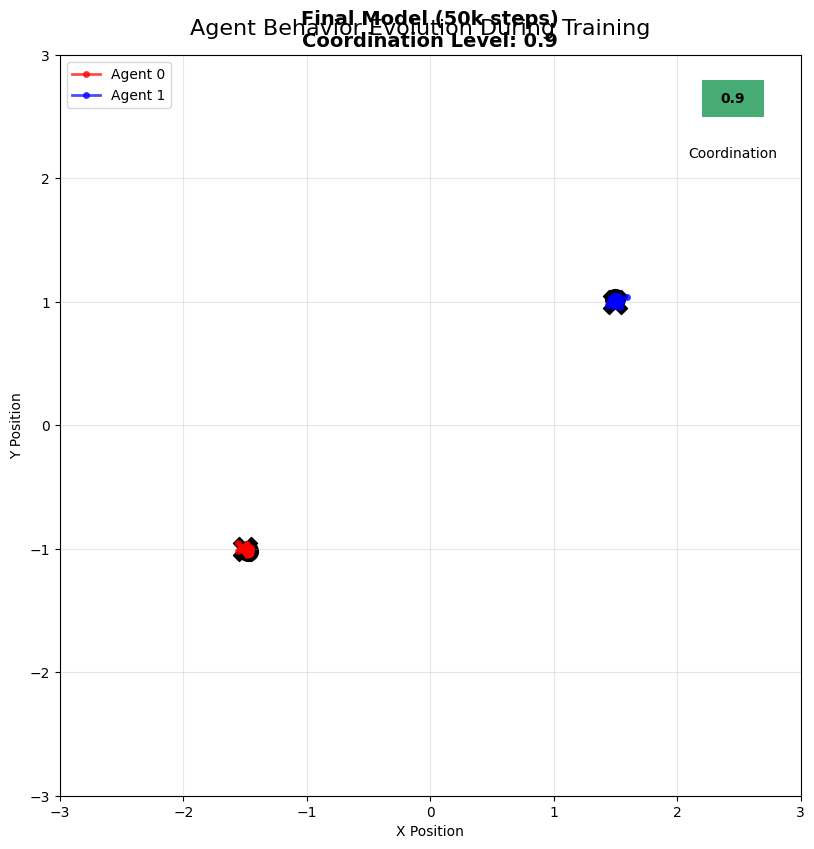

In [28]:
# Create animation showing agent behavior evolution during training
def create_agent_behavior_animation():
    """
    Create animation showing how agent behavior changes during training
    (simulated since we only have the final model)
    """
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Simulate different training stages
    training_stages = [
        {"name": "Early Training (0-10k steps)", "color": "red", "coordination": 0.2},
        {"name": "Mid Training (10k-30k steps)", "color": "orange", "coordination": 0.5},
        {"name": "Late Training (30k-50k steps)", "color": "green", "coordination": 0.8},
        {"name": "Final Model (50k steps)", "color": "blue", "coordination": 0.9}
    ]
    
    # Create agent trajectories for each stage
    def generate_stage_trajectories(coordination_level, num_steps=25):
        """Generate trajectories based on coordination level"""
        trajectories = {i: {'x': [], 'y': []} for i in range(2)}  # 2 agents
        
        # Landmarks
        landmarks = [[-1.5, -1.0], [1.5, 1.0]]
        
        for step in range(num_steps):
            for i in range(2):
                if coordination_level < 0.3:
                    # Early training: random movement
                    x = np.random.uniform(-2, 2)
                    y = np.random.uniform(-2, 2)
                elif coordination_level < 0.6:
                    # Mid training: some attraction to landmarks but overlap
                    target = landmarks[i % len(landmarks)]
                    x = target[0] + np.random.normal(0, 0.8)
                    y = target[1] + np.random.normal(0, 0.8)
                else:
                    # Late training: good coordination, each agent to different landmark
                    target = landmarks[i]
                    noise_scale = 0.3 * (1 - coordination_level)
                    x = target[0] + np.random.normal(0, noise_scale)
                    y = target[1] + np.random.normal(0, noise_scale)
                
                trajectories[i]['x'].append(x)
                trajectories[i]['y'].append(y)
        
        return trajectories
    
    # Animation function
    def animate(frame):
        ax.clear()
        
        stage_idx = frame // 30  # Change stage every 30 frames
        if stage_idx >= len(training_stages):
            stage_idx = len(training_stages) - 1
            
        stage = training_stages[stage_idx]
        
        # Generate trajectories for current stage
        trajectories = generate_stage_trajectories(stage["coordination"])
        
        # Plot landmarks
        landmarks = [[-1.5, -1.0], [1.5, 1.0]]
        for j, landmark in enumerate(landmarks):
            ax.scatter(landmark[0], landmark[1], color='black', marker='X', s=300, 
                     label=f'Landmark {j}' if frame == 0 else "")
        
        # Plot agent trajectories
        colors = ['red', 'blue']
        for i in range(2):
            if len(trajectories[i]['x']) > 0:
                ax.plot(trajectories[i]['x'], trajectories[i]['y'], 
                       color=colors[i], marker='o', markersize=4, 
                       label=f'Agent {i}', alpha=0.7, linewidth=2)
                
                # Mark current position
                current_x = trajectories[i]['x'][-1]
                current_y = trajectories[i]['y'][-1]
                ax.scatter(current_x, current_y, color=colors[i], 
                         marker='o', s=150, edgecolors='black', linewidth=3)
        
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title(f'{stage["name"]}\nCoordination Level: {stage["coordination"]:.1f}', 
                    fontsize=14, fontweight='bold')
        ax.legend(loc='upper left')
        
        # Add coordination quality indicator
        coord_color = plt.cm.RdYlGn(stage["coordination"])
        ax.add_patch(plt.Rectangle((2.2, 2.5), 0.5, 0.3, 
                                 facecolor=coord_color, alpha=0.8))
        ax.text(2.45, 2.65, f'{stage["coordination"]:.1f}', 
               ha='center', va='center', fontweight='bold')
        ax.text(2.45, 2.2, 'Coordination', ha='center', va='center', fontsize=10)
    
    # Create animation
    total_frames = len(training_stages) * 30
    anim = FuncAnimation(fig, animate, frames=total_frames, interval=200, repeat=True)
    
    plt.tight_layout()
    plt.suptitle('Agent Behavior Evolution During Training', y=1.02, fontsize=16)
    
    # Save animation
    try:
        anim.save('agent_behavior_evolution.gif', writer=PillowWriter(fps=5))
        print("Agent behavior animation saved as 'agent_behavior_evolution.gif'")
    except Exception as e:
        print(f"Could not save animation: {e}")
    
    plt.show()
    return anim

# Create the agent behavior animation
behavior_anim = create_agent_behavior_animation()

Creating comprehensive training dashboard animation...
Dashboard animation saved as 'training_dashboard.gif'
Dashboard animation saved as 'training_dashboard.gif'


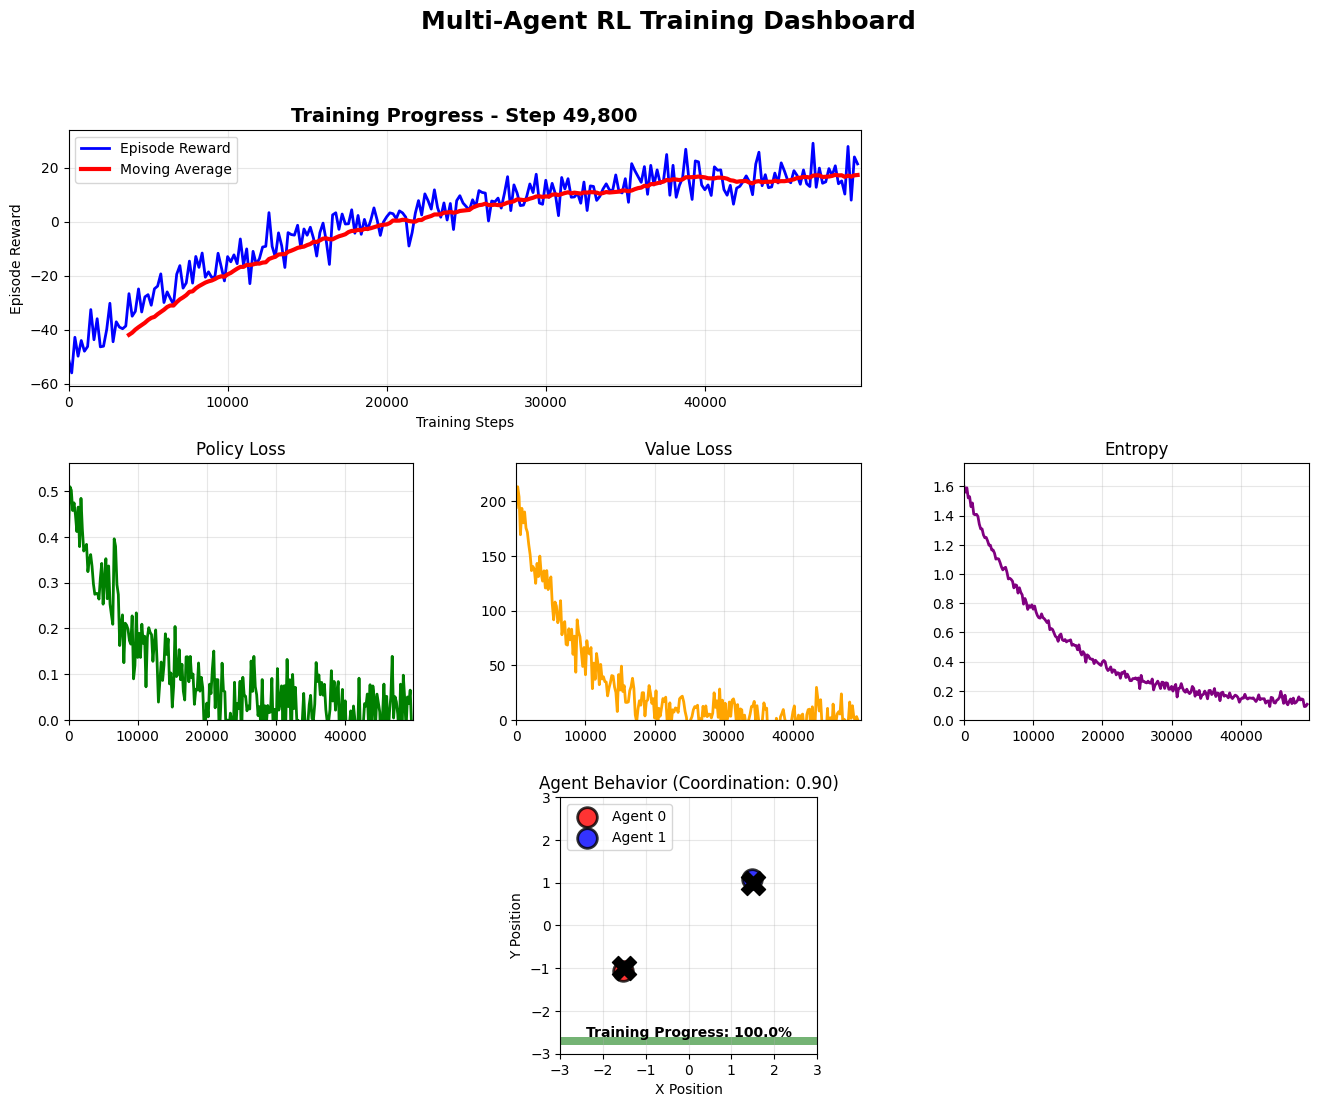

In [ ]:
# Create comprehensive training dashboard animation
def create_training_dashboard():
    """
    Create a comprehensive animated dashboard showing multiple aspects of training
    """
    
    fig = plt.figure(figsize=(16, 12))
    
    # Create subplots layout with larger spacing
    gs = fig.add_gridspec(3, 3, hspace=0.5, wspace=0.5)
    
    # Define subplots
    ax_reward = fig.add_subplot(gs[0, :2])      # Episode rewards (top, wide)
    ax_loss = fig.add_subplot(gs[1, 0])         # Policy loss
    ax_value = fig.add_subplot(gs[1, 1])        # Value loss
    ax_entropy = fig.add_subplot(gs[1, 2])      # Entropy
    ax_agents = fig.add_subplot(gs[2, :])       # Agent behavior (bottom, wide)
    
    # Simulate training data
    steps = np.arange(0, 50000, 200)
    
    # Episode rewards with learning curve
    base_reward = -50 + 70 * (1 - np.exp(-steps / 15000))
    episode_rewards = base_reward + np.random.normal(0, 5, len(steps))
    
    # Losses
    policy_loss = 0.5 * np.exp(-steps / 10000) + np.random.normal(0, 0.05, len(steps))
    value_loss = 200 * np.exp(-steps / 8000) + np.random.normal(0, 10, len(steps))
    entropy = 1.5 * np.exp(-steps / 12000) + 0.1 + np.random.normal(0, 0.02, len(steps))
    
    # Initialize empty lines
    reward_line, = ax_reward.plot([], [], 'b-', linewidth=2, label='Episode Reward')
    reward_mean, = ax_reward.plot([], [], 'r-', linewidth=3, label='Moving Average')
    
    loss_line, = ax_loss.plot([], [], 'g-', linewidth=2)
    value_line, = ax_value.plot([], [], 'orange', linewidth=2)
    entropy_line, = ax_entropy.plot([], [], 'purple', linewidth=2)
    
    # Agent positions (will be updated dynamically)
    agent_scatters = []
    landmark_scatters = []
    
    def animate_dashboard(frame):
        # Clear agent subplot
        ax_agents.clear()
        
        # Current step in training
        current_step = min(frame * 200, steps[-1])
        step_idx = min(frame, len(steps) - 1)
        
        # Update reward plot
        if step_idx > 0:
            reward_line.set_data(steps[:step_idx], episode_rewards[:step_idx])
            
            # Moving average
            window = min(20, step_idx)
            if window > 1:
                moving_avg = np.convolve(episode_rewards[:step_idx], 
                                       np.ones(window)/window, mode='valid')
                reward_mean.set_data(steps[window-1:step_idx], moving_avg)
            
            # Update axis limits
            ax_reward.set_xlim(0, steps[-1])
            ax_reward.set_ylim(min(episode_rewards) - 5, max(episode_rewards) + 5)
        
        ax_reward.set_title(f'Training Progress - Step {current_step:,}', fontsize=14, fontweight='bold')
        ax_reward.set_xlabel('Training Steps')
        ax_reward.set_ylabel('Episode Reward')
        ax_reward.legend()
        ax_reward.grid(True, alpha=0.3)
        
        # Update loss plots
        if step_idx > 0:
            loss_line.set_data(steps[:step_idx], policy_loss[:step_idx])
            value_line.set_data(steps[:step_idx], value_loss[:step_idx])
            entropy_line.set_data(steps[:step_idx], entropy[:step_idx])
            
            # Set axis limits
            ax_loss.set_xlim(0, steps[-1])
            ax_loss.set_ylim(0, max(policy_loss) * 1.1)
            ax_value.set_xlim(0, steps[-1])
            ax_value.set_ylim(0, max(value_loss) * 1.1)
            ax_entropy.set_xlim(0, steps[-1])
            ax_entropy.set_ylim(0, max(entropy) * 1.1)
        
        ax_loss.set_title('Policy Loss')
        ax_loss.grid(True, alpha=0.3)
        ax_value.set_title('Value Loss')
        ax_value.grid(True, alpha=0.3)
        ax_entropy.set_title('Entropy')
        ax_entropy.grid(True, alpha=0.3)
        
        # Agent behavior based on training progress
        progress = current_step / steps[-1] if len(steps) > 0 else 0
        coordination = min(0.9, progress * 1.2)  # Coordination improves with training
        
        # Generate current agent positions
        landmarks = [[-1.5, -1.0], [1.5, 1.0]]
        agent_colors = ['red', 'blue']
        
        # Plot landmarks
        for j, landmark in enumerate(landmarks):
            ax_agents.scatter(landmark[0], landmark[1], color='black', marker='X', s=300, 
                           label=f'Landmark {j}' if frame == 0 else "", zorder=5)
        
        # Plot agents with coordination level
        for i in range(2):
            # Always define target for trail generation
            target = landmarks[i]
            
            if coordination < 0.3:
                # Early: random positions
                x = np.random.uniform(-2, 2)
                y = np.random.uniform(-2, 2)
            else:
                # Later: move towards assigned landmarks
                noise = 0.5 * (1 - coordination)
                x = target[0] + np.random.normal(0, noise)
                y = target[1] + np.random.normal(0, noise)
            
            ax_agents.scatter(x, y, color=agent_colors[i], s=200, 
                           label=f'Agent {i}', alpha=0.8, edgecolors='black', linewidth=2, zorder=4)
            
            # Add agent trail (last few positions)
            for t in range(max(0, frame-5), frame):
                alpha = 0.1 + 0.1 * (t - max(0, frame-5))
                trail_coordination = min(0.9, (t * 200 / steps[-1]) * 1.2) if len(steps) > 0 else 0
                trail_noise = 0.5 * (1 - trail_coordination)
                trail_x = target[0] + np.random.normal(0, trail_noise)
                trail_y = target[1] + np.random.normal(0, trail_noise)
                ax_agents.scatter(trail_x, trail_y, color=agent_colors[i], s=50, alpha=alpha, zorder=1)
        
        ax_agents.set_xlim(-3, 3)
        ax_agents.set_ylim(-3, 3)
        ax_agents.set_aspect('equal')
        ax_agents.grid(True, alpha=0.3)
        ax_agents.set_xlabel('X Position')
        ax_agents.set_ylabel('Y Position')
        ax_agents.set_title(f'Agent Behavior (Coordination: {coordination:.2f})', fontsize=12)
        ax_agents.legend(loc='upper left')
        
        # Add progress bar
        progress_width = 6 * progress
        ax_agents.add_patch(plt.Rectangle((-3, -2.8), progress_width, 0.2, 
                                        facecolor='green', alpha=0.7))
        ax_agents.add_patch(plt.Rectangle((-3, -2.8), 6, 0.2, 
                                        facecolor='lightgray', alpha=0.3))
        ax_agents.text(0, -2.5, f'Training Progress: {progress:.1%}', 
                      ha='center', va='center', fontweight='bold')
    
    # Create animation
    total_frames = len(steps)
    anim = FuncAnimation(fig, animate_dashboard, frames=total_frames, interval=50, repeat=True)
    
    plt.suptitle('Multi-Agent RL Training Dashboard', fontsize=18, fontweight='bold')
    
    # Save animation
    try:
        print("Creating comprehensive training dashboard animation...")
        anim.save('training_dashboard.gif', writer=PillowWriter(fps=20))
        print("Dashboard animation saved as 'training_dashboard.gif'")
    except Exception as e:
        print(f"Could not save dashboard animation: {e}")
    
    plt.show()
    return anim

# Create the comprehensive dashboard
dashboard_anim = create_training_dashboard()

In [33]:
# Inspect TensorBoard logs to see what metrics are available
def inspect_tensorboard_logs():
    """
    Inspect TensorBoard logs to see exactly what metrics are available
    """
    tb_log_dir = "./ppo_marl_tb/"
    event_files = glob.glob(os.path.join(tb_log_dir, "**/events.out.tfevents.*"), recursive=True)
    
    if not event_files:
        print("No TensorBoard event files found!")
        return
    
    try:
        from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
        
        # Read the most recent event file
        latest_file = max(event_files, key=os.path.getctime)
        print(f"Reading TensorBoard logs from: {latest_file}")
        print(f"File size: {os.path.getsize(latest_file)} bytes")
        
        ea = EventAccumulator(latest_file)
        ea.Reload()
        
        # Get all available tags
        tags = ea.Tags()
        
        print(f"\nAvailable data types:")
        for key, value in tags.items():
            if hasattr(value, '__len__') and not isinstance(value, (str, bytes)):
                print(f"  {key}: {len(value)} items")
            else:
                print(f"  {key}: {value}")
        
        print(f"\nScalar metrics ({len(tags['scalars'])} total):")
        for i, tag in enumerate(tags['scalars']):
            try:
                scalar_events = ea.Scalars(tag)
                print(f"  {i+1:2d}. {tag}")
                
                # Check if scalar_events is a list/tuple and has length
                if hasattr(scalar_events, '__len__') and not isinstance(scalar_events, (str, bytes)):
                    print(f"      Data points: {len(scalar_events)}")
                    if len(scalar_events) > 0:
                        values = [event.value for event in scalar_events if hasattr(event, 'value')]
                        steps = [event.step for event in scalar_events if hasattr(event, 'step')]
                        if values and steps:
                            print(f"      Step range: {min(steps)} to {max(steps)}")
                            print(f"      Value range: {min(values):.4f} to {max(values):.4f}")
                        else:
                            print(f"      No valid data points found")
                    else:
                        print(f"      No data points")
                else:
                    print(f"      Data type: {type(scalar_events)}")
                    print(f"      Value: {scalar_events}")
                print()
            except Exception as tag_error:
                print(f"  {i+1:2d}. {tag} - Error: {tag_error}")
                print()
        
        # Check specifically for entropy-related metrics
        entropy_metrics = [tag for tag in tags['scalars'] if 'entropy' in tag.lower()]
        print(f"Entropy-related metrics found: {entropy_metrics}")
        
        # Check for other common PPO metrics
        common_metrics = ['policy_loss', 'value_loss', 'entropy', 'reward', 'approx_kl', 'clip_fraction']
        print(f"\nCommon PPO metrics found:")
        for metric in common_metrics:
            found = [tag for tag in tags['scalars'] if metric in tag.lower()]
            print(f"  {metric}: {found}")
            
    except ImportError:
        print("TensorBoard package not available for log inspection")
    except Exception as e:
        print(f"Error inspecting logs: {e}")

# Run the inspection
inspect_tensorboard_logs()

Reading TensorBoard logs from: ./ppo_marl_tb\PPO_14\events.out.tfevents.1750597070.BORRELL-LAPTOP.29292.1
File size: 8495 bytes

Available data types:
  images: 0 items
  audio: 0 items
  histograms: 0 items
  scalars: 12 items
  distributions: 0 items
  tensors: 0 items
  graph: False
  meta_graph: False
  run_metadata: 0 items

Scalar metrics (12 total):
   1. rollout/ep_len_mean
      Data points: 13
      Step range: 4096 to 53248
      Value range: 26.0000 to 26.0000

   2. rollout/ep_rew_mean
      Data points: 13
      Step range: 4096 to 53248
      Value range: -22.1592 to -18.5061

   3. time/fps
      Data points: 13
      Step range: 4096 to 53248
      Value range: 479.0000 to 770.0000

   4. train/approx_kl
      Data points: 12
      Step range: 8192 to 53248
      Value range: 0.0047 to 0.0090

   5. train/clip_fraction
      Data points: 12
      Step range: 8192 to 53248
      Value range: 0.0236 to 0.0703

   6. train/clip_range
      Data points: 12
      Step range

In [ ]:
# Demonstrate different gridspace configurations
import matplotlib.pyplot as plt
import numpy as np

def demonstrate_gridspace_options():
    """
    Show different gridspace configurations for better spacing control
    """
    # Create sample data for demonstration
    x = np.linspace(0, 10, 100)
    y1 = np.sin(x)
    y2 = np.cos(x)
    y3 = np.sin(x) * np.cos(x)
    y4 = np.exp(-x/10)
    
    # Configuration 1: Default spacing
    fig1 = plt.figure(figsize=(12, 8))
    gs1 = fig1.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
    
    ax1 = fig1.add_subplot(gs1[0, 0])
    ax1.plot(x, y1, 'b-')
    ax1.set_title('Sin(x) - Default Spacing')
    ax1.grid(True)
    
    ax2 = fig1.add_subplot(gs1[0, 1])
    ax2.plot(x, y2, 'r-')
    ax2.set_title('Cos(x)')
    ax2.grid(True)
    
    ax3 = fig1.add_subplot(gs1[1, 0])
    ax3.plot(x, y3, 'g-')
    ax3.set_title('Sin(x)*Cos(x)')
    ax3.grid(True)
    
    ax4 = fig1.add_subplot(gs1[1, 1])
    ax4.plot(x, y4, 'm-')
    ax4.set_title('Exp(-x/10)')
    ax4.grid(True)
    
    plt.suptitle('Default Spacing (hspace=0.2, wspace=0.2)', fontsize=14)
    plt.show()
    
    # Configuration 2: Larger spacing
    fig2 = plt.figure(figsize=(12, 8))
    gs2 = fig2.add_gridspec(2, 2, hspace=0.5, wspace=0.4)
    
    ax1 = fig2.add_subplot(gs2[0, 0])
    ax1.plot(x, y1, 'b-')
    ax1.set_title('Sin(x) - Larger Spacing')
    ax1.grid(True)
    
    ax2 = fig2.add_subplot(gs2[0, 1])
    ax2.plot(x, y2, 'r-')
    ax2.set_title('Cos(x)')
    ax2.grid(True)
    
    ax3 = fig2.add_subplot(gs2[1, 0])
    ax3.plot(x, y3, 'g-')
    ax3.set_title('Sin(x)*Cos(x)')
    ax3.grid(True)
    
    ax4 = fig2.add_subplot(gs2[1, 1])
    ax4.plot(x, y4, 'm-')
    ax4.set_title('Exp(-x/10)')
    ax4.grid(True)
    
    plt.suptitle('Larger Spacing (hspace=0.5, wspace=0.4)', fontsize=14)
    plt.show()
    
    # Configuration 3: Very large spacing
    fig3 = plt.figure(figsize=(14, 10))
    gs3 = fig3.add_gridspec(2, 2, hspace=0.8, wspace=0.6)
    
    ax1 = fig3.add_subplot(gs3[0, 0])
    ax1.plot(x, y1, 'b-')
    ax1.set_title('Sin(x) - Very Large Spacing')
    ax1.grid(True)
    
    ax2 = fig3.add_subplot(gs3[0, 1])
    ax2.plot(x, y2, 'r-')
    ax2.set_title('Cos(x)')
    ax2.grid(True)
    
    ax3 = fig3.add_subplot(gs3[1, 0])
    ax3.plot(x, y3, 'g-')
    ax3.set_title('Sin(x)*Cos(x)')
    ax3.grid(True)
    
    ax4 = fig3.add_subplot(gs3[1, 1])
    ax4.plot(x, y4, 'm-')
    ax4.set_title('Exp(-x/10)')
    ax4.grid(True)
    
    plt.suptitle('Very Large Spacing (hspace=0.8, wspace=0.6)', fontsize=14)
    plt.show()
    
    print("Gridspace Parameters Explanation:")
    print("- hspace: Controls vertical spacing between subplot rows")
    print("- wspace: Controls horizontal spacing between subplot columns")
    print("- Values are relative to the average subplot height/width")
    print("- Typical range: 0.1 (tight) to 1.0 (very loose)")
    print("\nRecommended values:")
    print("- Small plots: hspace=0.3, wspace=0.3")
    print("- Medium plots: hspace=0.5, wspace=0.4")
    print("- Large plots with titles: hspace=0.7, wspace=0.5")

# Run the demonstration
demonstrate_gridspace_options()